In [1]:
# Set your working directory
import os
os.chdir('/Location_of_src_folder')

import torch    
import h5py
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
#import umap
#import umap.plot
from dictionary_learning.autoencoder import SparseAutoencoder
import torch.nn.functional as F
from models.networks import get_model
#from data_utils.dataloader import get_loader
from CNN_models.vgg import vgg13_bn
from data_utils.data_stats import *
from utils.metrics import topk_acc, real_acc, AverageMeter
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 18})


Load trained autoencoder

In [2]:
cfg = {
    "seed": 49,
    "buffer_mult": 384,
    "l1_coeff": 3e-4,
    "dict_mult": 3, #expansion factor of the latent representation
    "d_activation": 4096,
    "enc_dtype":"fp32",
}

sparse_autoencoder = SparseAutoencoder(cfg)
sparse_autoencoder.load_state_dict(torch.load('./dictionary_learning/SAE_100_epochs_bs_32_CIFAR10_test_vgg_bn13.pt'))

<All keys matched successfully>

Load VGG

In [3]:
dataset = 'cifar10'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vgg = vgg13_bn(pretrained=True)
state_dict = os.path.join(
                "CNN_models", "state_dicts", "vgg13_bn" + ".pt"
            )
vgg.load_state_dict(torch.load(state_dict))

<All keys matched successfully>

Load dataset and targets

In [4]:
cifar10_labels = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}
class TrainDataset(Dataset):
    def __init__(self, data, targets):
        assert len(data.shape) == 4 and data.shape[1] == 3
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx, :, :, :]
        target = self.targets[idx]

        return sample, target


f = h5py.File("./dictionary_learning/ims_cifar10_train.h5", "r")

for key in f.keys():
    print(key) 
    print(type(f[key])) # get the object type   

group = f[key]
images = torch.tensor(group[:]).float()
print("Images Shape:", images.shape)

f = h5py.File("./dictionary_learning/targs_cifar10_train.h5", "r")

for key in f.keys():
    print(key) 
    print(type(f[key])) # get the object type   

group = f[key]
targets = torch.tensor(group[:]).float()
print("Targets Shape:", targets.shape)

train_data = TrainDataset(images[:10000], targets[:10000])
del images
del targets

images
<class 'h5py._hl.dataset.Dataset'>
Images Shape: torch.Size([50000, 3, 32, 32])
targets
<class 'h5py._hl.dataset.Dataset'>
Targets Shape: torch.Size([50000])


## Experiments

replace VGG activations with AE reconstructions to see how much of the accuracy is "explained" by the AE features (i.e., hidden activations)

In [5]:
encoded = []
counter = 0
mse_loss = 0
def replace_hook(module, input, output):
    global mse_loss, counter
    _, rec, acts, loss, _ = sparse_autoencoder(output)
    encoded.append(acts.detach().clone())
    mse_loss = (mse_loss*counter + loss.item())/(counter+1)
    counter += 1
    return rec.detach()

hook_vgg = vgg._modules['classifier'][4].register_forward_hook(replace_hook)

with torch.no_grad():
    nsamples = train_data.targets.shape[0]
    total_acc = AverageMeter()
    batchsize = 100
    vgg.eval()
    dataloader = DataLoader(train_data, batch_size=batchsize, shuffle=False)
    
    for imgs, targs in tqdm(dataloader, desc="Evaluation"):
        preds = vgg(imgs)
        acc, _ = topk_acc(preds, targs, k=5, avg=True)
        total_acc.update(acc, batchsize)

hook_vgg.remove()
print(f'Accuracy: {total_acc.get_avg(percentage=True)}')
print(f'SAE MSE: {mse_loss}')

Evaluation: 100%|██████████| 100/100 [04:05<00:00,  2.46s/it]

Accuracy: 99.9799998998642
SAE MSE: 0.0049012215109542


In [6]:
del vgg #deleting to save memory. If you have more memory you can get rid of this.
encoded = np.concatenate(encoded, axis=0)

# uncomment if you want to save the feature activations for the test set 
# with h5py.File('vgg13_bn_enc_' + dataset + '_train_1st_10k.h5', 'w') as hf:
#     hf.create_dataset('feature activations', data=encoded)

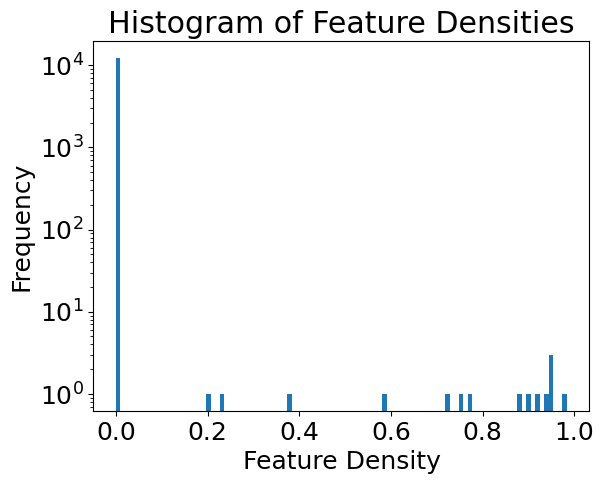

Number of active units in hidden AE-layer:  tensor(19.)
Feature densities of active units:  tensor([3.0000e-04, 2.0480e-01, 1.0000e-04, 2.3570e-01, 9.3980e-01, 9.8350e-01,
        2.0000e-04, 5.8310e-01, 9.1600e-01, 9.4710e-01, 3.7680e-01, 8.9910e-01,
        9.4640e-01, 8.8140e-01, 7.5190e-01, 1.0000e-04, 7.1830e-01, 7.7040e-01,
        9.4580e-01])


In [7]:
encoded = torch.from_numpy(encoded)
feature_densities = (encoded != 0).float().mean(dim=0).detach()
plt.hist(feature_densities, bins=100, log=True)
plt.xlabel('Feature Density')
plt.ylabel('Frequency')
plt.title('Histogram of Feature Densities')
plt.show()

active_units = feature_densities != 0
print("Number of active units in hidden AE-layer: ", active_units.float().sum())
print("Feature densities of active units: ", feature_densities[active_units])

## Interpreting non-silent features

Display top 10 activating inputs with corresponding labels for a given non-silent feature

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Showing top activating inputs for feature 1491:


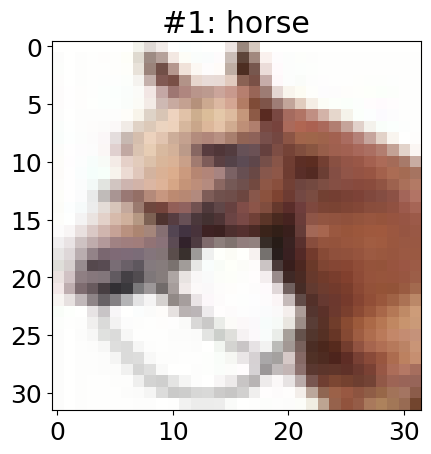

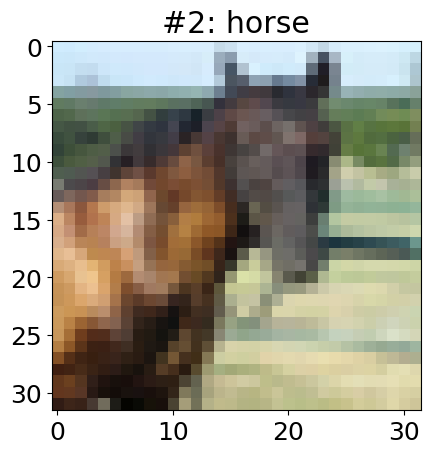

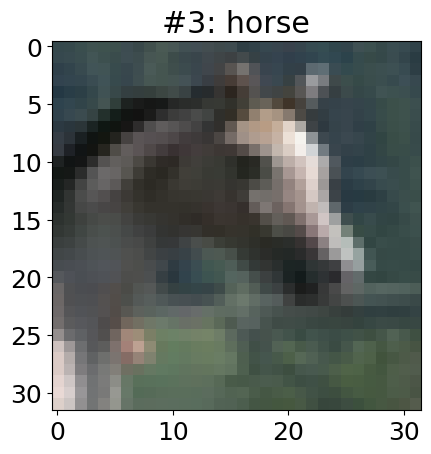

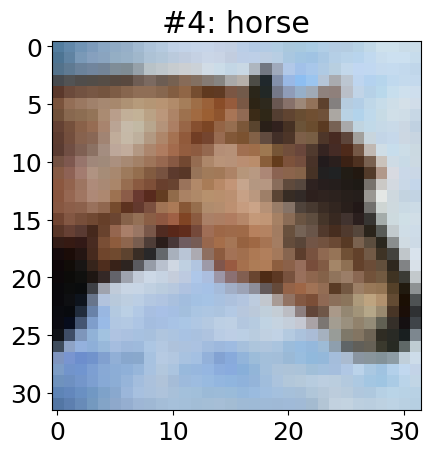

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


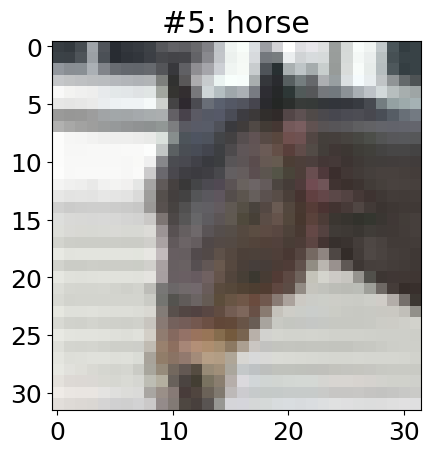

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


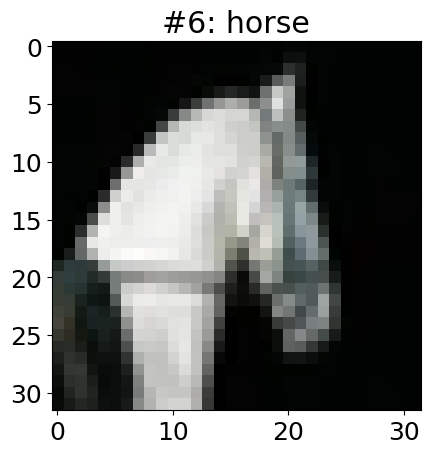

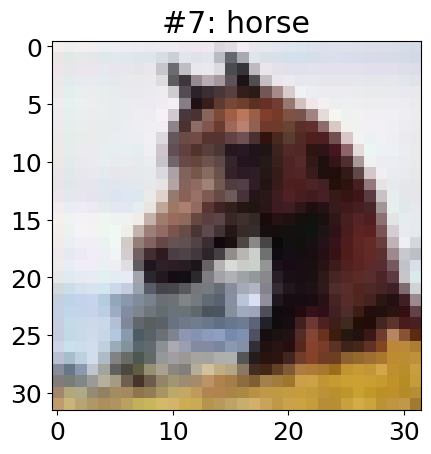

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


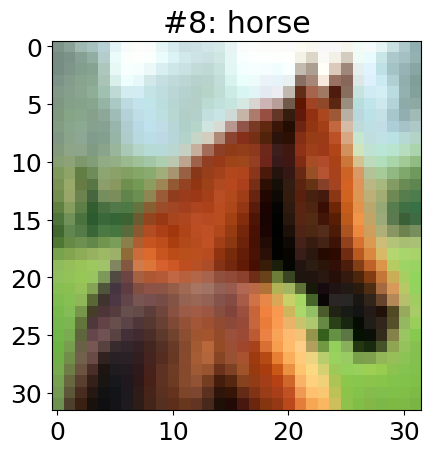

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


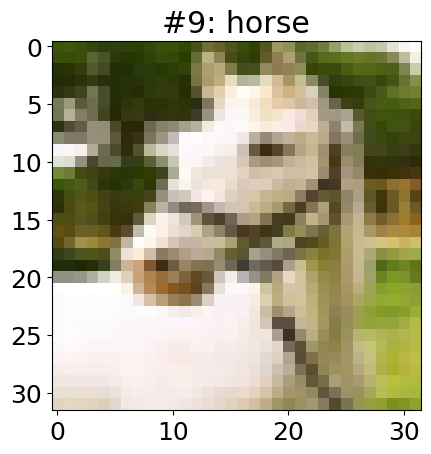

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


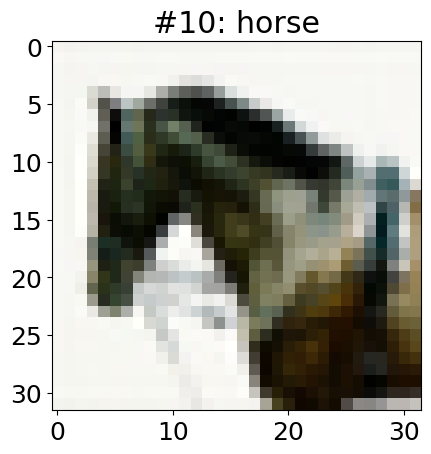

In [8]:
alive_idxs = torch.nonzero(active_units)
f_idx = alive_idxs[1] #change index to specify non-silent feature
f_acts = encoded[:, f_idx]
top_act_idxs = f_acts.abs().squeeze().topk(10)[1]
mu = np.array([0.4914, 0.4822, 0.4465]).reshape(1, 1, 3) #values taken from readme of https://github.com/huyvnphan/PyTorch_CIFAR10
sigma = np.array([0.2471, 0.2435, 0.2616]).reshape(1, 1, 3)

print(f' Showing top activating inputs for feature {f_idx.item()}:')
for i, top_idx in enumerate(top_act_idxs):
    img = np.transpose(np.squeeze(train_data.data[top_idx, :, :, :]), axes=(1, 2, 0))
    img = img*sigma + mu
    plt.imshow(img)
    plt.title(f'#{i+1}: {cifar10_labels[train_data.targets[top_idx].item()]}')
    plt.show()


Sensitivity/specificity 

In [9]:
feat_idx = 1
glob_idx = alive_idxs[feat_idx]
feature_labels = np.array(['?', 'horse', '?', 'dog', 'ship/deer', 'dog', '?', 'deer', 'ship', 'bird', 'automobile',
                  'airplane', 'cat', 'frog', 'frog', '?', 'airplane', 'bird', 'truck']) #these are the 
#labels derived from manual inspection of the top 10 activating images for each feature
idxs4labels = {v: k for k, v in cifar10_labels.items()}
l_idx = idxs4labels[feature_labels[feat_idx]]
l_occur_mask = (train_data.targets == l_idx)
n_occur = l_occur_mask.sum()
n_active_cond = (encoded[l_occur_mask, glob_idx] != 0).sum()
sensitivity = n_active_cond / n_occur
active_mask = (encoded[:, glob_idx].squeeze() != 0)
tn = (~(train_data.targets[~active_mask] == l_idx)).sum()
n = (~(train_data.targets == l_idx)).sum()
specificity = tn / n
print(f"Sensitivity of feature {glob_idx.item()} to hypothesised class {feature_labels[feat_idx]}: {sensitivity}")
print(f"Specificity of feature {glob_idx.item()} to hypothesised class {feature_labels[feat_idx]}: {specificity}")

Sensitivity of feature 1491 to hypothesised class horse: 1.0
Specificity of feature 1491 to hypothesised class horse: 0.48095703125


On/off is a very coarse way of looking at feature activations. Better to consider different activation levels.

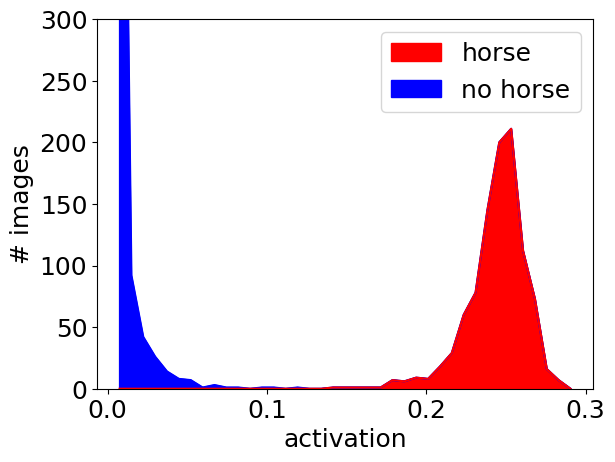

In [10]:
feat_idx = 1
glob_idx = alive_idxs[feat_idx]
label = feature_labels[feat_idx]
n_bins = 40
l_idx = idxs4labels[feature_labels[feat_idx]]
sing_f_acts = encoded[:, glob_idx]
max_act = sing_f_acts.abs().max().item()
min_act = sing_f_acts.abs().min().item()
act_bins = np.linspace(min_act, max_act, num=n_bins)    

num_TA = np.empty((n_bins-1))
num_FA = np.empty((n_bins-1))
for i_bin in range(len(act_bins)-1):
    left = act_bins[i_bin]
    right = act_bins[i_bin+1] 
    bin_act_mask = torch.logical_and(sing_f_acts.squeeze().abs() > left, sing_f_acts.squeeze().abs() < right)
    TA = (train_data.targets[bin_act_mask] == l_idx).sum()
    FA = bin_act_mask.sum() - TA
    num_TA[i_bin] = TA
    num_FA[i_bin] = FA

# Plotting the lines
plt.plot(act_bins[1:], num_TA + num_FA, color='blue')
plt.fill_between(act_bins[1:], 0, num_TA, color='red', label=label)

plt.plot(act_bins[1:], num_TA, color='red')
plt.fill_between(act_bins[1:], num_TA, num_TA + num_FA, color='blue', label='no ' + label)
plt.ylim([0, 300])
_ = plt.xlabel(f'activation')
_ = plt.ylabel('# images')
# _ = plt.title(f'Feature {glob_idx.item()} with hypothesized meaning "{label}"')
_ = plt.legend(loc='upper right')
#plt.savefig(f"figures_vgg/f{f_idx.item()}_sensitivity_by_act_{label}.png", format="png", bbox_inches="tight")
    

Recompute sensitivity/specificity while only considering the feature to be "active" if its activation is larger than 0.15.

In [11]:
feat_idx = 1
glob_idx = alive_idxs[feat_idx]
feature_labels = np.array(['?', 'horse', '?', 'dog', 'ship/deer', 'dog', '?', 'deer', 'ship', 'bird', 'automobile',
                  'airplane', 'cat', 'frog', 'frog', '?', 'airplane', 'bird', 'truck']) #these are the 
#labels derived from manual inspection of the top 10 activating images for each feature
idxs4labels = {v: k for k, v in cifar10_labels.items()}
l_idx = idxs4labels[feature_labels[feat_idx]]
l_occur_mask = (train_data.targets == l_idx)
n_occur = l_occur_mask.sum()
n_active_cond = (encoded[l_occur_mask, glob_idx] > 0.15).sum()
sensitivity = n_active_cond / n_occur
active_mask = (encoded[:, glob_idx].squeeze() > 0.15)
tn = (~(train_data.targets[~active_mask] == l_idx)).sum()
n = (~(train_data.targets == l_idx)).sum()
specificity = tn / n
print(f"Sensitivity of feature {glob_idx.item()} to hypothesised class {feature_labels[feat_idx]}: {sensitivity}")
print(f"Specificity of feature {glob_idx.item()} to hypothesised class {feature_labels[feat_idx]}: {specificity}")

Sensitivity of feature 1491 to hypothesised class horse: 0.9979695677757263
Specificity of feature 1491 to hypothesised class horse: 1.0


Investigate downstream effects of feature

In [12]:
#########deleting SAE and loading VGG to save memory##################################
f_vec = sparse_autoencoder.W_dec[glob_idx, :].squeeze()
del sparse_autoencoder
vgg = vgg13_bn(pretrained=True)
state_dict = os.path.join(
                "CNN_models", "state_dicts", "vgg13_bn" + ".pt"
            )
vgg.load_state_dict(torch.load(state_dict))
#######################################################################################

<All keys matched successfully>

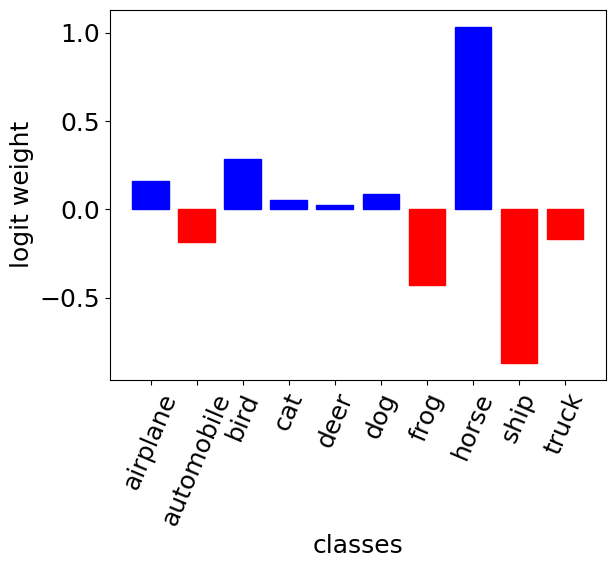

In [14]:
feat_idx = 1
glob_idx = alive_idxs[feat_idx]
label = feature_labels[feat_idx]

W_down = vgg.classifier[6].weight
logit_ws = W_down@f_vec

bars = plt.bar(cifar10_labels.values(), logit_ws.detach().numpy())
for bar in bars:
    if bar.get_height() < 0:
        bar.set_color('red')
    else:
        bar.set_color('blue')

_ = plt.xlabel('classes') 
_ = plt.ylabel('logit weight')
_ = plt.xticks(rotation=67)
#plt.savefig(f"figures_vgg/f{f_idx.item()}_logit_weights.png", format="png", bbox_inches="tight")

Causal manipulations: artifically pin the feature at large value and observe its downstream effects on classification behavior, i.e., show that the feature is **causally** driving the prediction of a certain class.

Evaluation: 100%|██████████| 100/100 [02:05<00:00,  1.25s/it]


# of horse-predictions: 0


Evaluation: 100%|██████████| 100/100 [02:04<00:00,  1.25s/it]


# of horse-predictions: 0


Evaluation: 100%|██████████| 100/100 [02:10<00:00,  1.31s/it]


# of horse-predictions: 0


Evaluation: 100%|██████████| 100/100 [02:13<00:00,  1.34s/it]


# of horse-predictions: 0


Evaluation: 100%|██████████| 100/100 [02:15<00:00,  1.35s/it]


# of horse-predictions: 0


Evaluation: 100%|██████████| 100/100 [02:11<00:00,  1.32s/it]


# of horse-predictions: 983


Evaluation: 100%|██████████| 100/100 [02:14<00:00,  1.34s/it]


# of horse-predictions: 990


Evaluation: 100%|██████████| 100/100 [02:11<00:00,  1.32s/it]


# of horse-predictions: 5825


Evaluation: 100%|██████████| 100/100 [02:10<00:00,  1.31s/it]


# of horse-predictions: 9718


Evaluation: 100%|██████████| 100/100 [02:08<00:00,  1.28s/it]


# of horse-predictions: 10000


Evaluation: 100%|██████████| 100/100 [02:07<00:00,  1.27s/it]


# of horse-predictions: 10000


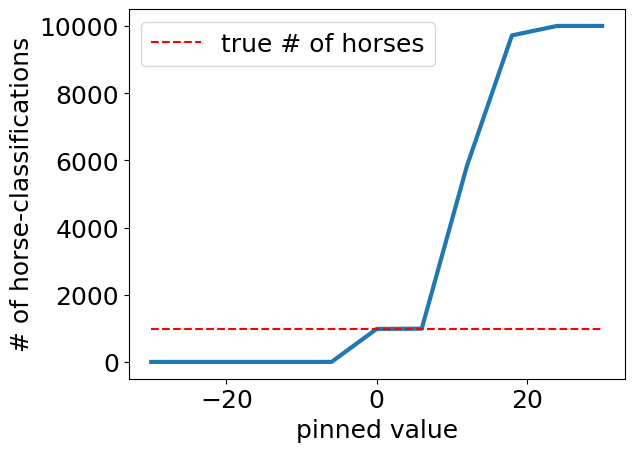

In [15]:
f_normed = f_vec / (f_vec.norm() + 1e-8)
pin_value = 0

def pin_hook(module, input, output):
    batch_size = output.shape[0]
    ablated = output-output@f_normed.view(-1, 1)@f_normed.view(1, -1)
    pinned = ablated + pin_value*f_normed.view(1, -1).expand(batch_size, -1)
    return pinned

hook_vgg = vgg._modules['classifier'][4].register_forward_hook(pin_hook)

with torch.no_grad():
    nsamples = train_data.targets.shape[0]
    total_acc, total_top5 = AverageMeter(), AverageMeter()
    batchsize = 100
    vgg.eval()
    dataloader = DataLoader(train_data, batch_size=batchsize, shuffle=False)
    label_idx = idxs4labels[label]
    pin_vals = np.linspace(-30, 30, 11)
    counts = []
    
    for val in pin_vals:
        pin_value = val
        counter = 0
        for imgs, targs in tqdm(dataloader, desc="Evaluation"):
            preds = vgg(imgs)
            hard_preds = preds.argmax(dim=1)
            counter += (hard_preds == label_idx).sum().item()
        
        print(f'# of {label}-predictions: {counter}')
        counts.append(counter)

hook_vgg.remove()

n_true_inst = (train_data.targets == l_idx).sum().item()
plt.plot(pin_vals, counts, linewidth=3)
plt.hlines(n_true_inst, pin_vals[0], pin_vals[-1], linestyles="dashed", colors="red", label=f"true # of {label}s")
_ = plt.xlabel('pinned value') 
_ = plt.ylabel(f'# of {label}-classifications')
_ = plt.legend()
#plt.savefig(f"figures_vgg/f{glob_idx.item()}_pinned_num_{label}_preds.png", format="png", bbox_inches="tight")